# Data exploration
First let's import the data.

In [9]:
# !pip install python-mnist
from mnist import MNIST

mndata = MNIST('.')
mndata.gz = True

images, labels = mndata.load_training()
images = [np.array(i).reshape((28, 28)) for i in images]

images_t, labels_t = mndata.load_testing()
images_t = [np.array(i).reshape((28, 28)) for i in images_t]

Now let's see how the images look like.

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

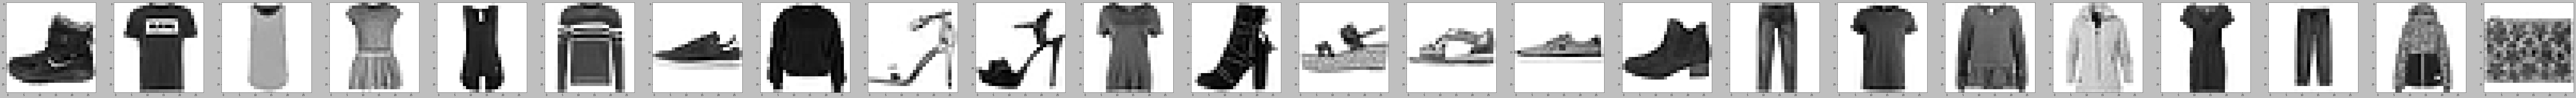

In [14]:
# display a small sample
plt.style.use('grayscale')
fig = plt.figure(figsize=(200,10))
n = 24
for i in range(n):
    plt.subplot(1, n, 1 + i)
    plt.imshow(1 - images[i])

plt.show()

And the same for the test data:

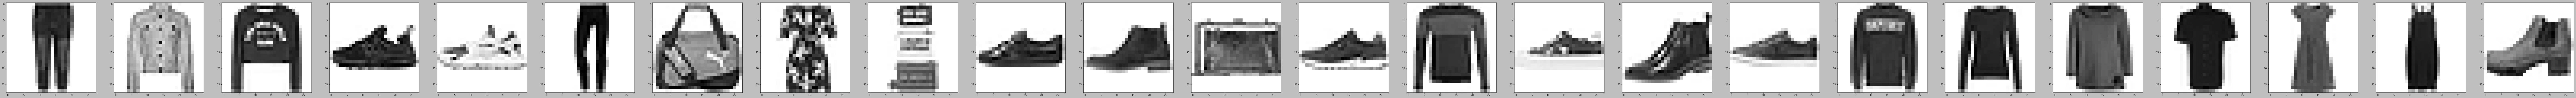

In [15]:
fig = plt.figure(figsize=(200,10))
start = 3000
for i in range(start, start+24):
    plt.subplot(1, 24, 1 + i - start)
    plt.imshow(1 - images_t[i])
plt.style.use('grayscale')

Check the distribution of the data between classes.

In [17]:
categorized = np.array([[x for x, y in zip(images, labels) if y == i] for i in range(10)])
for i in categorized:
    print(len(i))

6000
6000
6000
6000
6000
6000
6000
6000
6000
6000


It's exactly equal.  
Now let's generate a mean image for each category.

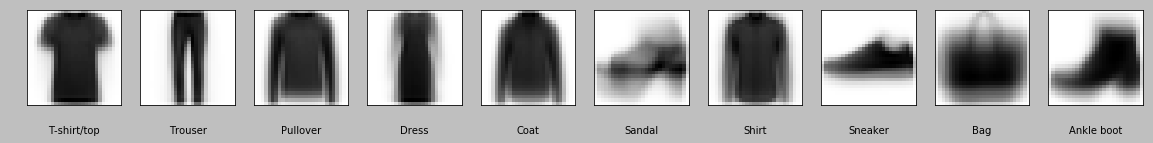

In [18]:
str_labels = [
 'T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot'
]


means = np.mean(categorized, axis=1)
fig = plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, 1 + i)
    plt.imshow(1 - means[i])
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel(str_labels[i])


plt.grid(False)
plt.show()

### Now let's see if they provide a valid model

In [154]:
n = len(images)
correct = 0
op = np.mean
for i in range(n):
    if labels[i] == np.argmin([op(i) for i in np.abs(np.subtract(means, images[i]))]):
        correct += 1
correct / n
# op=mean   gives accuracy 0.6125666666666667
# op=sum    gives accuracy 0.6125666666666667
# op=median gives accuracy 0.3148666666666667

0.6125666666666667

Not the best. 
Let's try to look at the image classes manually and deduce something from that

In [156]:
n = len(categorized[0])
n

6000

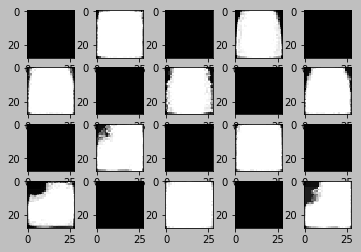

In [19]:
for i in range(10):
    plt.subplot(4, 5, 1 + 2 * i)
    plt.imshow(np.min(categorized[i], axis=0))
    plt.subplot(4, 5, 1 + 2 * i + 1)
    plt.imshow(np.max(categorized[i], axis=0))
plt.show()

The average images gave us important information: all of the clothing has the same orientation. This suggests that, unlike in a real life scenario, this dataset will punish augmentation by anything that is not a symmetry on the general shape of that category. This means that nothing can be augmented using rotation, everything aside from shoes can be reflected along the vertical axis, and shear can be used for everything. It is worth mentioning that the shoe images distinctly differ from the others, so it might be worth training a model that decides between shoes and everything else and ensembling it with two specific models.

DISCLAIMER: I used cuda when training the models, so if running the cells provides a slightly different accuracy it is because cuda results are different than cpu results.

## First model
I took the first model from the ["What is torch.nn really?"](https://pytorch.org/tutorials/beginner/nn_tutorial.html) tutorial. It was created for the MNIST dataset, so MNIST-fashion was easy to swap into it.

In [202]:
import torch
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, TensorDataset
from contextlib import contextmanager
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

cuda = torch.device("cuda")
cpu = torch.device("cpu")
dev = cuda if torch.cuda.is_available() else cpu

@contextmanager
def switch_to_cpu(model):
    global dev
    _dev = dev
    dev = cpu
    model.to(cpu)
    yield
    dev = _dev
    model.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def get_model():
    return nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
        nn.AvgPool2d(4),
        Lambda(lambda x: x.view(x.size(0), -1)),
    )


def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def predict_batch(model, data_loader):
    reals = []
    preds = []
    for xb, yb in data_loader:
        reals.append(yb)
        preds.append(model(xb).argmax(dim=1))
        
    return (torch.cat(reals, 0), torch.cat(preds, 0))

def accuracy(model, data_loader):
    return accuracy_score(*predict_batch(model, data_loader))

def loss(model, loss_func, data_loader):
    losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in data_loader])
    return np.sum(np.multiply(losses, nums)) / np.sum(nums)



def fit(model, loss_func, opt, train_dl, *, valid_dl=None, max_epochs=20, threshold=1e-6, min_epochs=None, silent=False):
    validation = valid_dl is not None
    print("Fitting a model...")
    last_loss = float("inf")
    epoch = 1
    accuracies = []
    losses = []
    while True:
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        model.eval()
        
        with torch.no_grad(), switch_to_cpu(model):
            # print diagnostics about current epoch
            if validation:
                val_loss = loss(model, loss_func, valid_dl)
                val_acc = accuracy(model, valid_dl)
            train_loss = loss(model, loss_func, train_dl)
            train_acc = accuracy(model, train_dl)
        if not silent:
            if validation:
                print("Epoch %s: val_loss=%s, train_loss=%s, val_acc=%s, train_acc=%s" % (epoch, val_loss, train_loss, val_acc, train_acc))
            else:
                print("Epoch %s: train_loss=%s, train_acc=%s" % (epoch, train_loss, train_acc))
        
        losses.append((val_loss, train_loss) if validation else train_loss)
        accuracies.append((val_acc, train_acc) if validation else train_acc)
        
        compare_loss = (val_loss if validation else train_loss)
        min_epochs_satisified = min_epochs is None or epoch >= min_epochs
        
        # stop execution
        if threshold and last_loss - compare_loss < threshold and min_epochs_satisified:
            print("delta loss %s was lower than threshold %s, stopping" % (last_loss - compare_loss, threshold))
            break
        
        if max_epochs is not None and epoch >= max_epochs and min_epochs_satisified:
            print("Max epochs reached, stopping")
            break
        last_loss = compare_loss
        epoch += 1
    return np.array([losses, accuracies])


def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

def get_dl(xs, ys, prep=preprocess, bs=30):
    return WrappedDataLoader(DataLoader(TensorDataset(xs.type(torch.float32), ys), batch_size=bs), prep)

def get_dls(xs, ys, prep=preprocess, bs=30):
    n = len(ys) // 5
    return {'valid': get_dl(xs[:n], ys[:n], prep, bs), 'train': get_dl(xs[n:], ys[n:], prep, bs)}
        
torch.manual_seed(213742069)
torch.cuda.manual_seed_all(213742069)
torch.cuda.manual_seed(213742069)
train = FashionMNIST('.', download=True, train=True)
        
first_model = get_model()
first_model.to(dev)
dls = get_dls(train.train_data, train.train_labels)
results = fit(first_model, F.cross_entropy, torch.optim.Adam(first_model.parameters()), dls['train'], valid_dl=dls['valid'], min_epochs=50, max_epochs=50)
print("DONE!")


Fitting a model...
Epoch 1: val_loss=0.5526910855993629, train_loss=0.5479524940159172, val_acc=0.80875, train_acc=0.8084166666666667
Epoch 2: val_loss=0.5106594758294523, train_loss=0.4975370693113655, val_acc=0.8233333333333334, train_acc=0.8284375
Epoch 3: val_loss=0.4740779356472194, train_loss=0.4531716490816325, val_acc=0.8363333333333334, train_acc=0.8458125
Epoch 4: val_loss=0.4503608988597989, train_loss=0.4230966140655801, val_acc=0.8455833333333334, train_acc=0.85575
Epoch 5: val_loss=0.43839116958901286, train_loss=0.4047118210978806, val_acc=0.85025, train_acc=0.861625
Epoch 6: val_loss=0.4244538502302021, train_loss=0.38843817736487835, val_acc=0.8555833333333334, train_acc=0.8661458333333333
Epoch 7: val_loss=0.41642708846367893, train_loss=0.37737021789886055, val_acc=0.8565833333333334, train_acc=0.86975
Epoch 8: val_loss=0.40523153365589676, train_loss=0.36669491589069364, val_acc=0.8605833333333334, train_acc=0.8733541666666667
Epoch 9: val_loss=0.4013443415146321, t

This achieved a Kaggle score of around 0.85, so decent but not the best. Let's see some statistics.

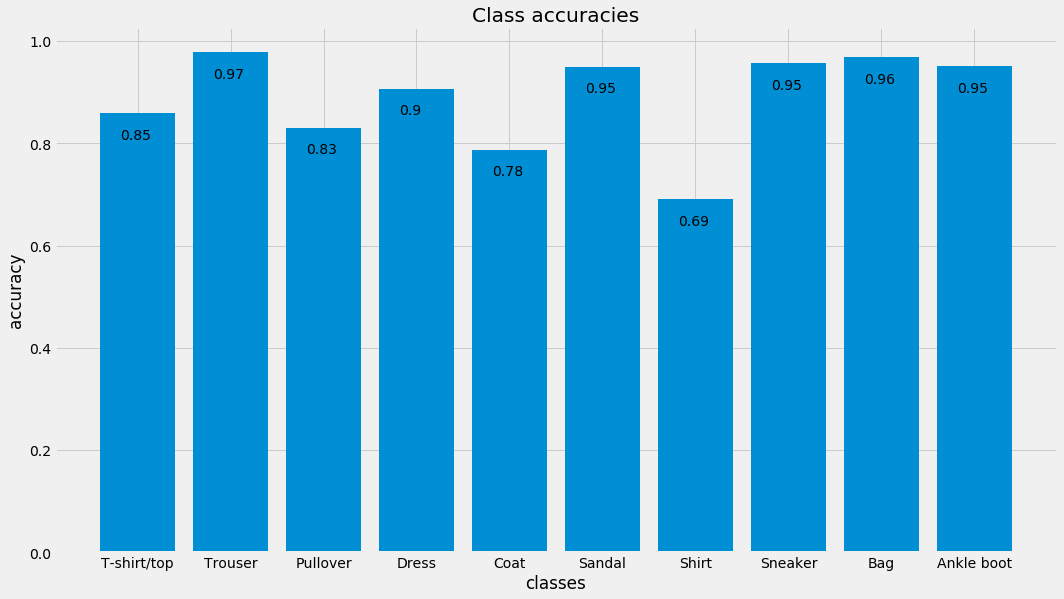

In [198]:
acc = []
with switch_to_cpu(first_model):
    for y, xs in enumerate(categorized):
        n = len(xs)
        ys = y * torch.ones(n)
        xs = next(iter(get_dl(torch.from_numpy(xs), ys, preprocess, n)))[0]
        acc.append(accuracy_score(ys, first_model(xs).argmax(dim=1)))

plt.figure(figsize=(16, 9))
plt.bar(str_labels, acc)
for i, v in enumerate(acc):
    plt.text(i - 0.19,  v - 0.05,  v * 100 // 1 / 100)
plt.xlabel('classes')
plt.ylabel('accuracy')
plt.title('Class accuracies')
plt.show()

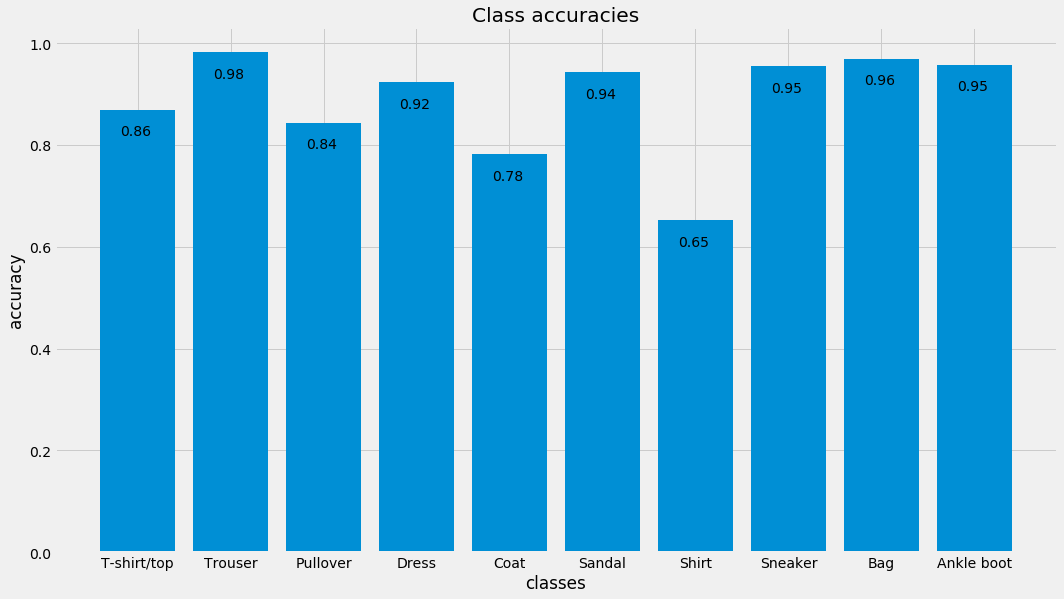

In [184]:
acc = []
with switch_to_cpu(first_model):
    for y, xs in enumerate(categorized):
        n = len(xs)
        ys = y * torch.ones(n)
        xs = next(iter(get_dl(torch.from_numpy(xs), ys, preprocess, n)))[0]
        acc.append(accuracy_score(ys, first_model(xs).argmax(dim=1)))

plt.figure(figsize=(16, 9))
plt.bar(str_labels, acc)
for i, v in enumerate(acc):
    plt.text(i - 0.19,  v - 0.05,  v * 100 // 1 / 100)
plt.xlabel('classes')
plt.ylabel('accuracy')
plt.title('Class accuracies')
plt.show()

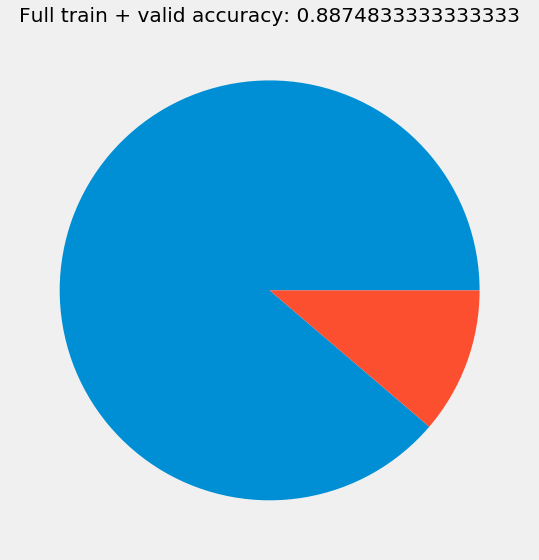

In [201]:
with switch_to_cpu(first_model):
    preds = first_model(next(iter(get_dl(train.train_data, train.train_labels, preprocess, 10000000)))[0]).argmax(dim=1)
    acc = accuracy_score(train.train_labels, preds)
plt.figure(figsize=(16, 9))
plt.pie([acc, 1 - acc])
plt.title("Full train + valid accuracy: %s" % acc) 
plt.show()

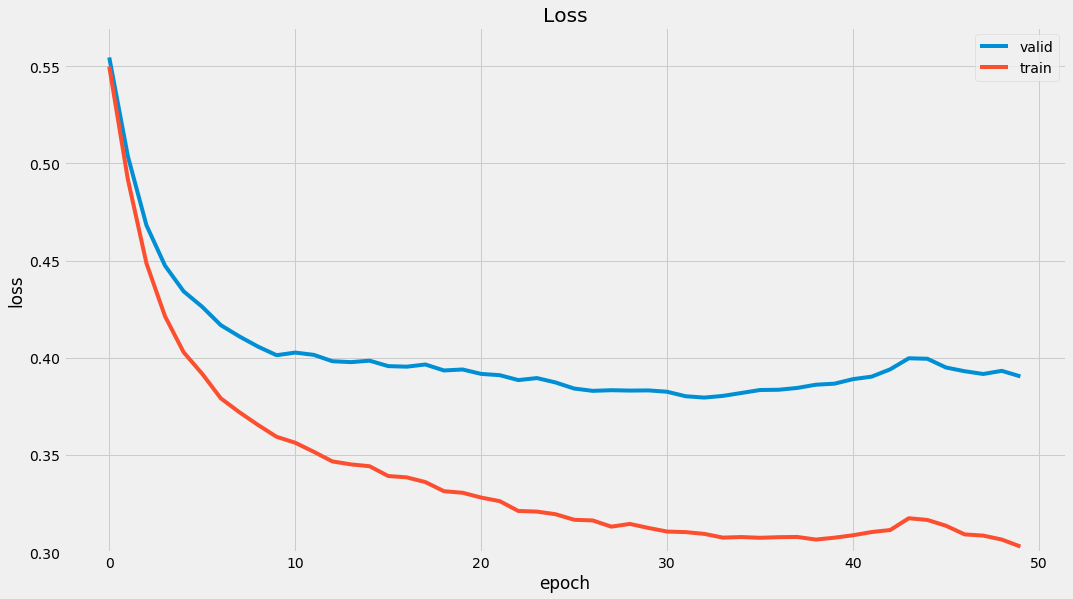

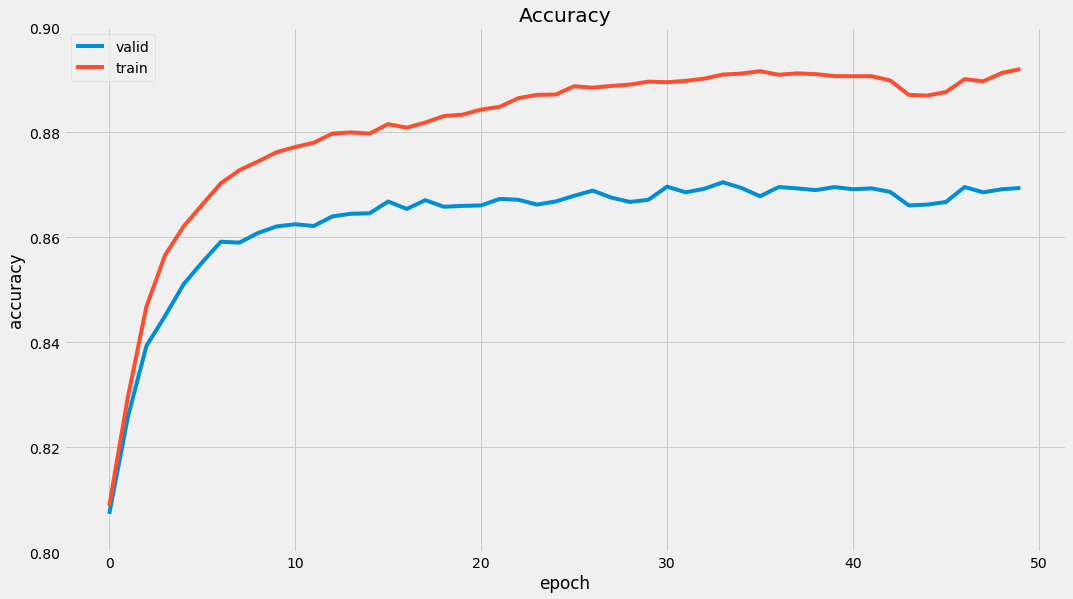

In [186]:
for i, (title, ylimits) in enumerate(zip(['Loss', 'Accuracy'], [(0.3, 0.57), (0.80, 0.9)])):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(16, 9))
    plt.plot(results[i, :, 0], label='valid')
    plt.plot(results[i, :, 1], label='train')
    plt.ylim(*ylimits)
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(title.lower())
    plt.legend()
    plt.show()

We see that the loss on validation reaches the minimum almost immediately, even though the accuracy still climbs until the end.  
Furthermore, it is really bad at detecting shirts, with only 65% accuracy. 

Next thing I tried was ensembling 3 separate models as discussed earlier.

In [187]:
# Warning: takes at least 15 minutes to run
def get_model(n_classes=10):
    return nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, n_classes, kernel_size=3, stride=2, padding=1),
        nn.AdaptiveMaxPool2d(1),
        Lambda(lambda x: x.view(x.size(0), -1)),
    )

boots = [5, 7, 9]
not_boots = [i for i in range(10) if i not in boots]

def prep_ens(x, y):
    for i in range(10):
        y[y == i] = int(i in boots)
    return preprocess(x, y)

def prep_indexer(indexer):
    def prep(x, y):
        for i, k in enumerate(indexer):
            y[y == k] = i
        return preprocess(x, y)
    return prep
    

# torch.manual_seed_all(213742069)
torch.manual_seed(213742069)

torch.cuda.manual_seed_all(213742069)
torch.cuda.manual_seed(213742069)


train = FashionMNIST('.', download=True, train=True)

data_loaders = [get_dls(train.train_data, train.train_labels, prep_ens)]

mask_y = torch.stack([train.train_labels == i for i in boots]).max(dim=0)[0]
mask_x = mask_y.view(-1, 1, 1).repeat(1, 28, 28)

data_loaders.append(get_dls(train.train_data.masked_select(mask_x).view(-1, 28, 28), train.train_labels.masked_select(mask_y), prep_indexer(boots)))
mask_x, mask_y = 1 - mask_x, 1 - mask_y
data_loaders.append(get_dls(train.train_data.masked_select(mask_x).view(-1, 28, 28), train.train_labels.masked_select(mask_y), prep_indexer(not_boots)))

boot_models = [get_model(2), get_model(3), get_model(7)]
min_epochs = [5, 20, 20]
max_epochs = [7, 25, None]
results = []
for model, dl, min_epoch, max_epoch in zip(boot_models, data_loaders, min_epochs, max_epochs):
    model.to(dev)
    model.apply(initer)
    train_dl, valid_dl = (dl, None) if dl.__class__ == WrappedDataLoader else dl
    result = fit(
        model,
        F.cross_entropy,
        torch.optim.Adam(model.parameters()), 
        dl['train'], 
        valid_dl=dl['valid'], 
        max_epochs=50,
        threshold=None
    )
    results.append(result)
print("DONE!")

Fitting a model...
Epoch 1: val_loss=0.03177053200241062, train_loss=0.0269404846614907, val_acc=0.9925, train_acc=0.9927916666666666
Epoch 2: val_loss=0.02875354914342097, train_loss=0.01894247602521091, val_acc=0.9931666666666666, train_acc=0.9946875
Epoch 3: val_loss=0.027449069019712623, train_loss=0.020631811359398854, val_acc=0.99125, train_acc=0.9937291666666667
Epoch 4: val_loss=0.02142320572078461, train_loss=0.013537983417830902, val_acc=0.9946666666666667, train_acc=0.9962291666666667
Epoch 5: val_loss=0.026730750122651442, train_loss=0.021493070092810172, val_acc=0.9938333333333333, train_acc=0.9942916666666667
Epoch 6: val_loss=0.011128763059413132, train_loss=0.007461787064294469, val_acc=0.99675, train_acc=0.998
Epoch 7: val_loss=0.013137532618417254, train_loss=0.005485329374577077, val_acc=0.99625, train_acc=0.9984166666666666
Epoch 8: val_loss=0.011942409827047341, train_loss=0.004074983893282655, val_acc=0.9970833333333333, train_acc=0.9989375
Epoch 9: val_loss=0.013

Epoch 15: val_loss=0.17832281629671343, train_loss=0.09344083582400345, val_acc=0.9488888888888889, train_acc=0.9673611111111111
Epoch 16: val_loss=0.17916097966954111, train_loss=0.08886010242567863, val_acc=0.9488888888888889, train_acc=0.9682638888888889
Epoch 17: val_loss=0.1886899228557013, train_loss=0.08870314963642159, val_acc=0.9447222222222222, train_acc=0.9676388888888889
Epoch 18: val_loss=0.1928223234465501, train_loss=0.08938842389106867, val_acc=0.9466666666666667, train_acc=0.9679861111111111
Epoch 19: val_loss=0.19713185065969205, train_loss=0.09421799454066786, val_acc=0.9425, train_acc=0.9667361111111111
Epoch 20: val_loss=0.21699046009258988, train_loss=0.1044924845922651, val_acc=0.9394444444444444, train_acc=0.9634027777777778
Epoch 21: val_loss=0.2099114538092787, train_loss=0.09940359295893965, val_acc=0.94, train_acc=0.9649305555555555
Epoch 22: val_loss=0.23313268955389504, train_loss=0.12446813895342833, val_acc=0.9402777777777778, train_acc=0.959375
Epoch 23

Epoch 30: val_loss=0.5947163447737693, train_loss=0.4810225177223661, val_acc=0.7936904761904762, train_acc=0.8214880952380952
Epoch 31: val_loss=0.5823782649955579, train_loss=0.46168010380518226, val_acc=0.7980952380952381, train_acc=0.8291964285714286
Epoch 32: val_loss=0.5971712702619177, train_loss=0.47753881449545066, val_acc=0.7891666666666667, train_acc=0.8250595238095239
Epoch 33: val_loss=0.6007202641772372, train_loss=0.47937916767384325, val_acc=0.7934523809523809, train_acc=0.8204761904761905
Epoch 34: val_loss=0.6074583819402116, train_loss=0.4836313148561333, val_acc=0.7916666666666666, train_acc=0.8184523809523809
Epoch 35: val_loss=0.6085839598838773, train_loss=0.48538327501155437, val_acc=0.7910714285714285, train_acc=0.8220238095238095
Epoch 36: val_loss=0.5941057663410902, train_loss=0.46552985936536323, val_acc=0.7917857142857143, train_acc=0.8257738095238095
Epoch 37: val_loss=0.6049917557942016, train_loss=0.4738355405296066, val_acc=0.7935714285714286, train_ac

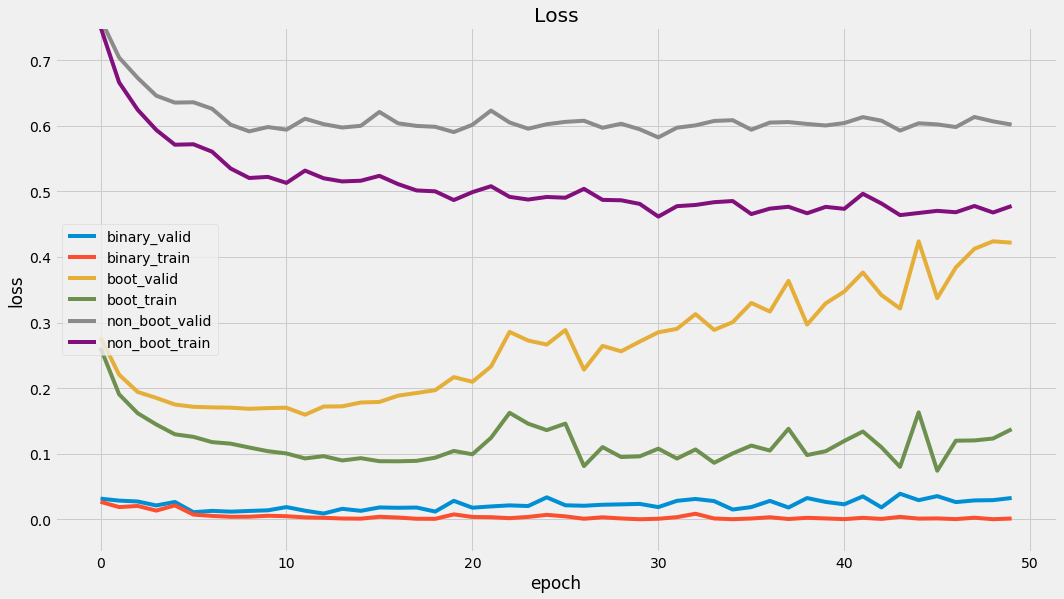

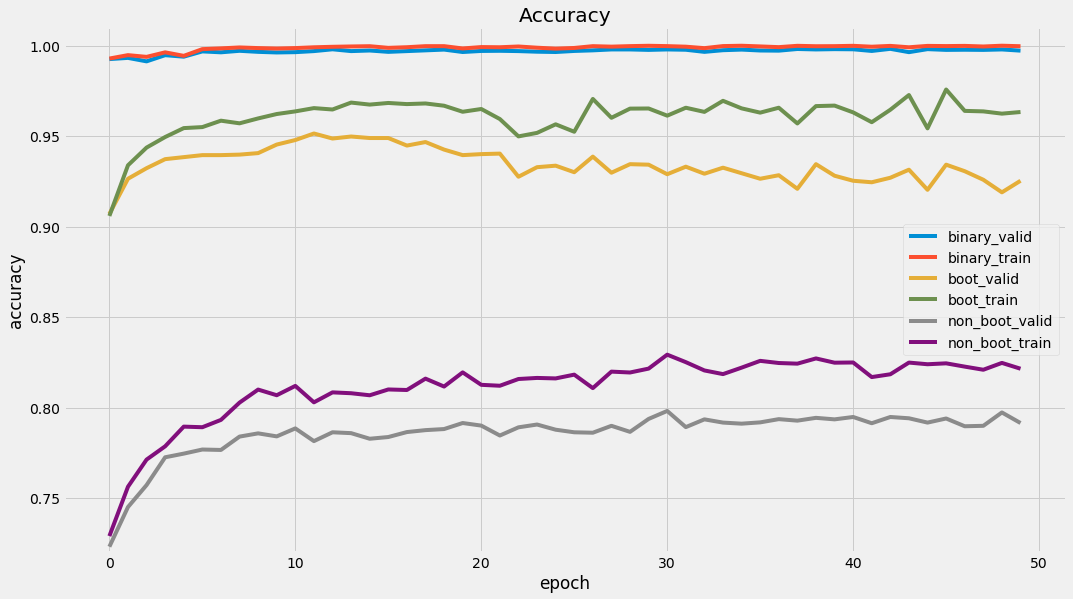

In [188]:
results = np.array(results)
for i, (title, ylimits) in enumerate(zip(['Loss', 'Accuracy'], [(-0.05, 0.75), (0.72, 1.01)])):
    plt.figure(figsize=(16, 9))
    for acc, label in zip(results[:, i], ['binary', 'boot', 'non_boot']):
        plt.plot(acc[:, 0], label=label + '_valid')
        plt.plot(acc[:, 1], label=label + '_train')
    plt.ylim(*ylimits)
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(title.lower())
    plt.legend()
    plt.show()

The plots don't appear like we fixed the issues mentioned earlier, let's see the prediction accuracy though.

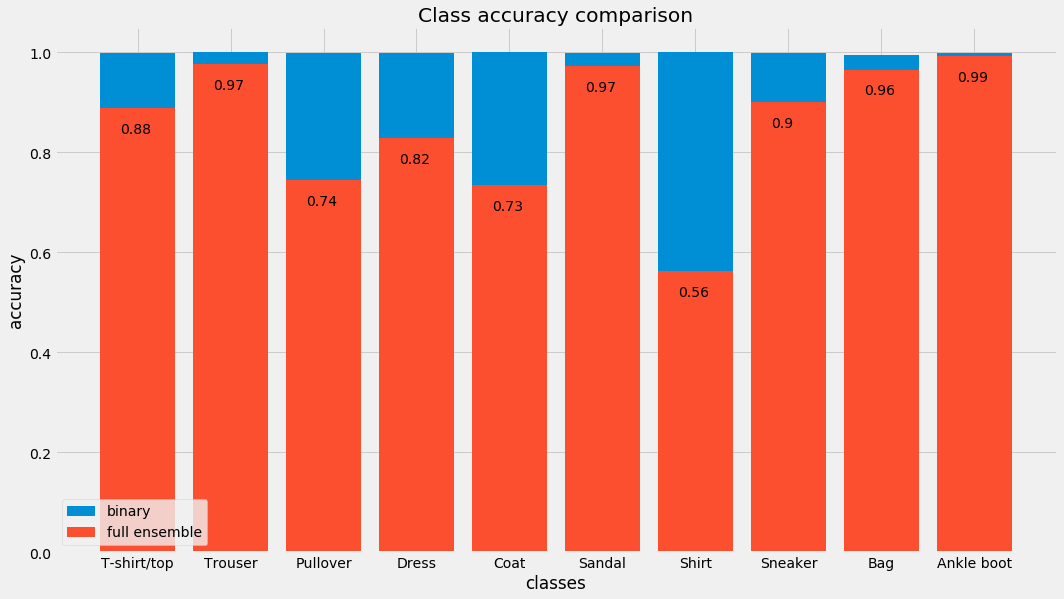

In [190]:
def predict(X):
    X1 = boot_models[0](X)
    X1 = X1.argmax(dim=1)
    X2 = []
    for i, x in enumerate(X1):
        # x == 1 means binary model thinks it's a boot
        res = boot_models[2 - x](X[i].view(1, 1, 28, 28))
        val = res.argmax(dim=1).item()
        X2.append(boots[val] if x == 1 else not_boots[val])
    
    return torch.tensor(X2), X1

accs_cat = []
accs_cat_binary = []
with switch_to_cpu(boot_models[0]), switch_to_cpu(boot_models[1]), switch_to_cpu(boot_models[2]):
    for i, cat in enumerate(categorized):
        n = len(cat)
        ys = i * torch.ones(n)
        trains = next(iter(get_dl(torch.from_numpy(cat), ys, prep_ens, n)))
        preds = predict(trains[0])
        accs_cat.append(accuracy_score(ys, preds[0]))
        accs_cat_binary.append(accuracy_score(trains[1], preds[1]))

plt.figure(figsize=(16, 9))
plt.bar(range(10), accs_cat_binary, label='binary')
plt.bar(str_labels, accs_cat, label='full ensemble')
for i, v in enumerate(accs_cat):
    plt.text(i - 0.19,  v - 0.05,  v * 100 // 1 / 100)
plt.title("Class accuracy comparison")
plt.xlabel('classes')
plt.ylabel('accuracy')
plt.legend(loc=3)
plt.show()

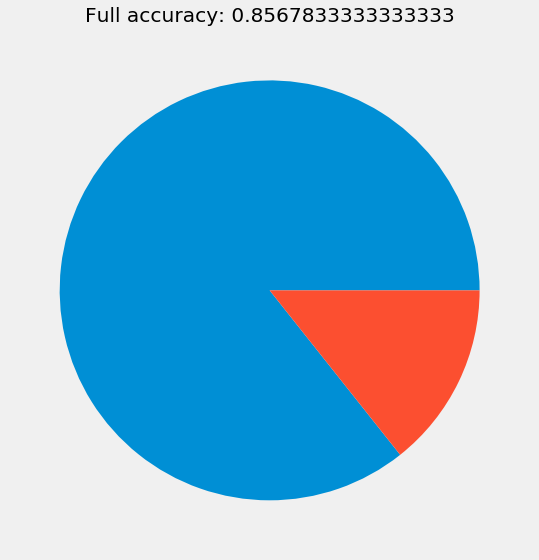

In [191]:
with switch_to_cpu(boot_models[0]), switch_to_cpu(boot_models[1]), switch_to_cpu(boot_models[2]):
    trains = next(iter(get_dl(train.train_data, train.train_labels, prep_ens, 10000000)))
    preds = predict(trains[0])
    acc_full = accuracy_score(train.train_labels, preds[0])

plt.figure(figsize=(16, 9))
plt.pie([acc_full, 1 - acc_full])
plt.title("Full accuracy: %s" % acc_full) 
plt.show()

Firstly, the net performs really well at deciding if something belongs to one of the 3 boot classes. However, the subnets show significantly lower accuracy, which is reflected by the end results: the train set accuracy actually decreased by a few percent compared to the first model and the kaggle score suffered a similar loss. But let's check if it improved any single class.

In [193]:
with torch.no_grad(), switch_to_cpu(boot_models[0]), switch_to_cpu(boot_models[1]), switch_to_cpu(boot_models[2]), switch_to_cpu(first_model):
    acc = np.ones(10)
    for y, xs in enumerate(categorized):
        n = len(xs)
        ys = y * torch.ones(n)
        xs = next(iter(get_dl(torch.from_numpy(xs), ys, preprocess, n)))[0]
        acc[y] = accuracy_score(ys, first_model(xs).argmax(dim=1))

    accs_cat = np.ones(10)
    for i, cat in enumerate(categorized):
        n = len(cat)
        ys = i * torch.ones(n)
        trains = next(iter(get_dl(torch.from_numpy(cat), ys, prep_ens, n)))
        preds = predict(trains[0])
        accs_cat[i] = accuracy_score(ys, preds[0])


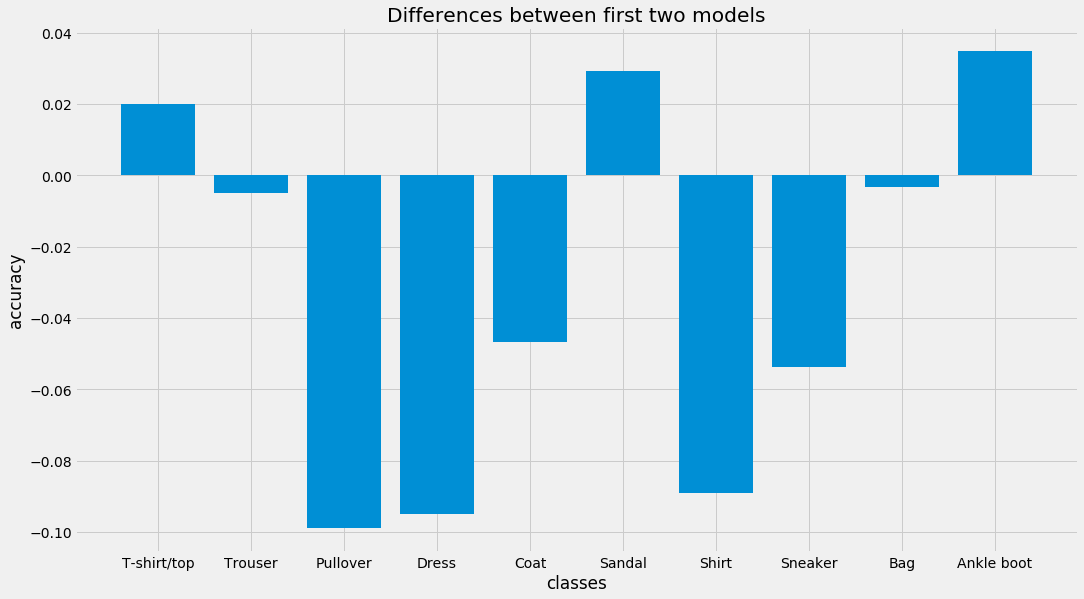

In [194]:
plt.figure(figsize=(16, 9))
plt.bar(str_labels, accs_cat - acc)
plt.title("Differences between first two models")
plt.xlabel('classes')
plt.ylabel('accuracy')

plt.show()

This looks like it suffered losses on almost all classes, so no point trying that further. 

However, the time has come for data augmentation. Let's stick with the first model and benchmark different augmentations on that. I used the same process as above to check the usefulness of the following augmentation methods:

In [208]:
import torchvision.transforms as tt
from transforms import RandomErasing # https://github.com/zhunzhong07/Random-Erasing/blob/master/transforms.py

aff = tt.Compose([
    tt.RandomAffine(0, translate=(1 / 10, 1/10), shear=10, fillcolor=0),
    tt.ToTensor()
])
re = tt.Compose([
    tt.ToTensor(),
    Lambda(lambda x: x.view(1, 28, 28)),
    RandomErasing() 
])
hflip = tt.Compose([
    tt.RandomHorizontalFlip()
])

Sad

In [203]:
test = FashionMNIST('.', download=True, train=False)
test_dl = get_dl(test.test_data, torch.ones(test.test_data.size(0)), preprocess, 10000)
with switch_to_cpu(first_model):
    preds = first_model(next(iter(test_dl))[0])#[0]
preds = preds.argmax(dim=1)
import pandas as pd
df = pd.DataFrame()
df['Class'] = preds
df.index.name = 'Id'
df.to_csv('submission.csv')
df

,Class
Id,
0,9
1,2
2,1
3,1
4,6
5,1
6,4
7,6
8,5
